## Package preparation

In [1]:
import os
import time

import numpy as np
import pandas as pd
from sklearn.utils import shuffle, resample
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.contrib import rnn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print("Package is ready.")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Package is ready.


In [2]:
matplotlib.rcParams['figure.figsize'] = ((8/2.54)*2, (6/2.54)*2)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 12})
MARKER_SIZE = 2
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

In [3]:
TIME_STEPS = 168
OUTPUT_SIZE = 1 # next 6h
N_FOLD = 5
N_TASKS = 6

INTERVAL = "1h"

EX_PRED = 0
EXPLANATION_ = "Ion_open_LN" + "_I" + INTERVAL + "_T" + str(TIME_STEPS)
print(EXPLANATION_)

Ion_open_LN_I1h_T168


## Data preparation

In [4]:
ion_label = pd.read_excel("../data/SW_Ion/Ion concentration_meq_20171109-20180426.xlsx", skiprows=1, index_col="date")

In [5]:
ion_label = ion_label[~(ion_label.index < '2017-11-17')]
#ion_label.drop(["N.1"], axis=1, inplace=True)
ion_label.drop(["K", "Ca", "Mg", "S", "N", "P"], axis=1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if "Unnamed:" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".2" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".3" in columns], axis= 1, inplace=True)
ion_label.dropna(inplace=True)
#ion_label.drop([pd.Timestamp("2018-04-23"), pd.Timestamp("2018-04-12"), pd.Timestamp("2018-04-05")], axis=0, inplace=True)
ion_label.drop([pd.Timestamp("2018-04-05"), pd.Timestamp("2018-04-13")], axis=0, inplace=True)

In [6]:
ion_label.index += pd.Timedelta("16h")

In [7]:
ion_label = ion_label.sample(frac=1.0)

In [8]:
raw_open = pd.read_csv("./results/open_data.csv", index_col="TIMESTAMP")
raw_open.index = pd.DatetimeIndex(raw_open.index)
raw_open = raw_open[np.abs(raw_open-raw_open.mean())<=(3*raw_open.std())]
raw_open["RootTemp(2)"][0] = 20
raw_open.drop(["ECS(4)", "InjDrgVR(4)", "DrgDaily(4)", "DrgV(4)"], axis=1, inplace=True)
#raw_open.drop(["MixTnkpH(4)", "RWEC(4)", "InjDrgVR(4)", "DrgDaily(4)"], axis=1, inplace=True)

In [9]:
raw_open.interpolate("linear", inplace=True)

# raw_open.index = (raw_open.index).round(INTERVAL)
# raw_open = raw_open.groupby(raw_open.index).mean()

In [10]:
MAXS = raw_open.max()
MINS = raw_open.min()
LABELMAXS = ion_label.max()
LABELMINS = ion_label.min()

In [11]:
raw_open = (raw_open - MINS) / (MAXS - MINS)
ion_label = (ion_label - LABELMINS) / (LABELMAXS - LABELMINS)

In [12]:
env_input = []
for index in ion_label.index:
    last_time = index
    first_time = last_time - pd.Timedelta(INTERVAL)*(TIME_STEPS-1)
    
    TRAIN_RANGE = pd.date_range(first_time, last_time, freq=INTERVAL)
    env_input.append(raw_open.loc[TRAIN_RANGE])

In [13]:
for i in range(len(env_input)):
    env_input[i] = env_input[i].values
    
env_input = np.array(env_input)

In [14]:
env_input.shape

(64, 168, 23)

In [15]:
rnn_inputs = []
rnn_labels = []
pred_inputs = []
pred_labels = []

N_TEST = int(ion_label.shape[0]/N_FOLD)

for i in range(N_FOLD-1):
    pred_inputs.append(env_input[i*N_TEST:(i+1)*N_TEST, :, :])
    pred_labels.append(ion_label.iloc[i*N_TEST:(i+1)*N_TEST, :])
    
    rnn_inputs.append(np.delete(env_input, np.arange(i*N_TEST, (i+1)*N_TEST), 0))
    rnn_labels.append(ion_label.drop(ion_label.index[np.arange(i*N_TEST, (i+1)*N_TEST)], axis=0))



pred_inputs.append(env_input[(N_FOLD-1)*N_TEST:, :, :])
pred_labels.append(ion_label.iloc[(N_FOLD-1)*N_TEST:, :])

rnn_inputs.append(env_input[:(N_FOLD-1)*N_TEST:, :, :])
rnn_labels.append(ion_label.iloc[:(N_FOLD-1)*N_TEST:, :])

In [16]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

## Network

1 fold start.
Epoch:        0/   50000 cost: 0.501016, best: 0.000
Training Acc: -5.182, Test Acc: -6.763
-16.352 -19.643 -12.177 -0.291 -0.671 -0.547 
-8.280225504549142
Epoch:      500/   50000 cost: 0.005066, best: 0.000
Training Acc: 0.933, Test Acc: 0.688
0.239 0.609 0.756 0.728 0.597 0.804 
0.6223804162908619
Epoch:     1000/   50000 cost: 0.001628, best: 0.000
Training Acc: 0.976, Test Acc: 0.696
0.463 0.552 0.796 0.827 0.379 0.900 
0.6528110113646255
Epoch:     1002/   50000 cost: 0.001551, best: 0.702 *Best value was replaced.
0.463 0.552 0.796 0.827 0.379 0.900 
0.6528110113646255
Epoch:     1014/   50000 cost: 0.001490, best: 0.708 *Best value was replaced.
0.463 0.552 0.796 0.827 0.379 0.900 
0.6528110113646255
Epoch:     1028/   50000 cost: 0.001768, best: 0.709 *Best value was replaced.
0.463 0.552 0.796 0.827 0.379 0.900 
0.6528110113646255
Epoch:     1046/   50000 cost: 0.003152, best: 0.717 *Best value was replaced.
0.463 0.552 0.796 0.827 0.379 0.900 
0.65281101136462

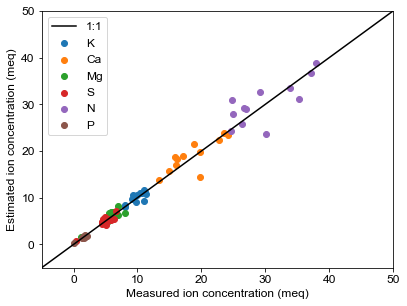

6 fold ended.
2 fold start.
Epoch:        0/   50000 cost: 1.077127, best: 0.000
Training Acc: -11.349, Test Acc: -15.695
0.379 -1.941 -49.530 -57.293 -13.041 -61.457 
-30.480403332113426
Epoch:      500/   50000 cost: 0.004683, best: 0.000
Training Acc: 0.934, Test Acc: 0.778
0.750 0.744 0.549 0.530 0.881 0.494 
0.6578690673678723
Epoch:     1000/   50000 cost: 0.002098, best: 0.000
Training Acc: 0.967, Test Acc: 0.687
0.762 0.413 0.670 0.642 0.483 0.408 
0.5628840138849565
Epoch:     1003/   50000 cost: 0.003120, best: 0.688 *Best value was replaced.
0.762 0.413 0.670 0.642 0.483 0.408 
0.5628840138849565
Epoch:     1004/   50000 cost: 0.002761, best: 0.693 *Best value was replaced.
0.762 0.413 0.670 0.642 0.483 0.408 
0.5628840138849565
Epoch:     1005/   50000 cost: 0.003355, best: 0.724 *Best value was replaced.
0.762 0.413 0.670 0.642 0.483 0.408 
0.5628840138849565
Epoch:     1009/   50000 cost: 0.002604, best: 0.726 *Best value was replaced.
0.762 0.413 0.670 0.642 0.483 0.408 

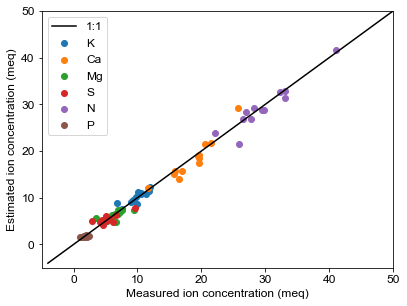

6 fold ended.
3 fold start.
Epoch:        0/   50000 cost: 0.848405, best: 0.000
Training Acc: -7.891, Test Acc: -8.897
-1.226 -0.190 -28.863 -2.692 -4.642 -40.922 
-13.089249494216013
Epoch:      500/   50000 cost: 0.002756, best: 0.000
Training Acc: 0.942, Test Acc: 0.752
0.694 0.695 0.842 0.916 0.660 0.872 
0.7798037663865998
Epoch:     1000/   50000 cost: 0.001802, best: 0.000
Training Acc: 0.973, Test Acc: 0.629
0.342 0.621 0.682 0.816 0.617 0.797 
0.6459186475055475
Epoch:     1003/   50000 cost: 0.001869, best: 0.633 *Best value was replaced.
0.342 0.621 0.682 0.816 0.617 0.797 
0.6459186475055475
Epoch:     1004/   50000 cost: 0.002261, best: 0.678 *Best value was replaced.
0.342 0.621 0.682 0.816 0.617 0.797 
0.6459186475055475
Epoch:     1005/   50000 cost: 0.002063, best: 0.721 *Best value was replaced.
0.342 0.621 0.682 0.816 0.617 0.797 
0.6459186475055475
Epoch:     1011/   50000 cost: 0.001343, best: 0.725 *Best value was replaced.
0.342 0.621 0.682 0.816 0.617 0.797 
0.

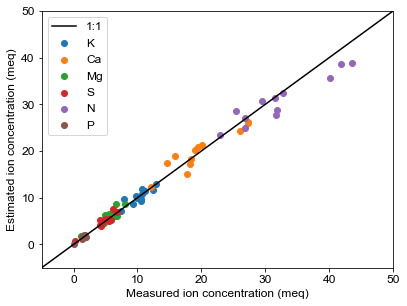

6 fold ended.
4 fold start.
Epoch:        0/   50000 cost: 0.292259, best: 0.000
Training Acc: -1.982, Test Acc: -0.977
-1.782 0.041 -0.065 -3.962 -0.763 -0.620 
-1.1918062560022233
Epoch:      500/   50000 cost: 0.004479, best: 0.000
Training Acc: 0.914, Test Acc: 0.725
0.651 0.835 0.567 0.715 0.775 0.722 
0.7107666105344964
Epoch:     1000/   50000 cost: 0.001724, best: 0.000
Training Acc: 0.956, Test Acc: 0.638
0.700 0.798 0.426 0.542 0.735 0.599 
0.6333347772081636
Epoch:     1003/   50000 cost: 0.002320, best: 0.622 *Best value was replaced.
0.700 0.798 0.426 0.542 0.735 0.599 
0.6333347772081636
Epoch:     1004/   50000 cost: 0.002612, best: 0.649 *Best value was replaced.
0.700 0.798 0.426 0.542 0.735 0.599 
0.6333347772081636
Epoch:     1006/   50000 cost: 0.002285, best: 0.667 *Best value was replaced.
0.700 0.798 0.426 0.542 0.735 0.599 
0.6333347772081636
Epoch:     1036/   50000 cost: 0.003312, best: 0.669 *Best value was replaced.
0.700 0.798 0.426 0.542 0.735 0.599 
0.633

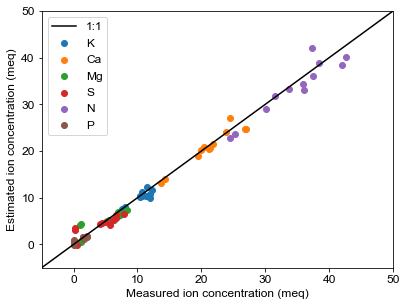

6 fold ended.
5 fold start.
Epoch:        0/   50000 cost: 0.611064, best: 0.000
Training Acc: -4.820, Test Acc: -4.370
-1.464 -15.853 -0.706 -0.053 -15.038 0.044 
-5.511674646304004
Epoch:      500/   50000 cost: 0.003234, best: 0.000
Training Acc: 0.940, Test Acc: 0.768
0.714 0.590 0.790 0.790 0.672 0.876 
0.7387880985906333
Epoch:     1000/   50000 cost: 0.001836, best: 0.000
Training Acc: 0.963, Test Acc: 0.657
0.661 0.586 0.634 0.549 0.614 0.711 
0.6258219855580779
Epoch:     1003/   50000 cost: 0.003344, best: 0.658 *Best value was replaced.
0.661 0.586 0.634 0.549 0.614 0.711 
0.6258219855580779
Epoch:     1008/   50000 cost: 0.001285, best: 0.663 *Best value was replaced.
0.661 0.586 0.634 0.549 0.614 0.711 
0.6258219855580779
Epoch:     1009/   50000 cost: 0.001589, best: 0.675 *Best value was replaced.
0.661 0.586 0.634 0.549 0.614 0.711 
0.6258219855580779
Epoch:     1020/   50000 cost: 0.002194, best: 0.678 *Best value was replaced.
0.661 0.586 0.634 0.549 0.614 0.711 
0.62

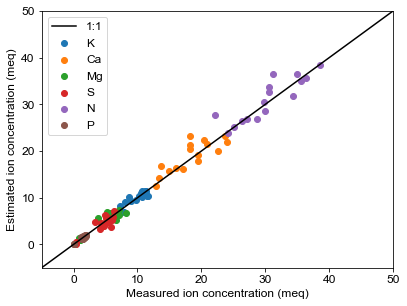

6 fold ended.
All fold vaildation were ended.
5-fold validation accuracy: 0.779


In [17]:
accuracies = []
for i in range(N_FOLD):
    print("%d fold start." % (i+1))

    pred_input = pred_inputs[i]
    pred_label = pred_labels[i]
    
    rnn_input = rnn_inputs[i]
    rnn_label = rnn_labels[i]
    
    # Parameters
    EXPLANATION = EXPLANATION_+ "_F" + str(i+1)
    LIMIT = 3002
    SHIELD = 1000
    
    global_step = tf.Variable(0, trainable=False)
    LEARNING_RATE = tf.train.exponential_decay(0.02, global_step, 3000, 0.96, staircase=True)
    EPSILON = 0.00001
    TRAINING_EPOCHS = 50000
    N_HIDDEN = 6
    DROP_PROB = 0.9
    BATCH_SIZE = 16
    DISPLAY_STEP = 500
    N_INPUT = env_input[0].shape[1]
    N_OUTPUT = ion_label.shape[1]

    # tf Graph input
    x = tf.placeholder("float", [None, TIME_STEPS, N_INPUT])
    y = tf.placeholder("float", [None, N_OUTPUT])
    drop_prob = tf.placeholder("float")
    phase = tf.placeholder(tf.bool)
    
    # Define weights
    weights = tf.get_variable("F"+ str(i+1) + "wgt", shape=[N_HIDDEN, N_OUTPUT], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable("F"+ str(i+1) + "bias", shape=[N_OUTPUT], initializer=tf.contrib.layers.xavier_initializer())
    variable_summaries(weights)
    variable_summaries(biases)

    def RNN(x, weights, biases, drop_prob):

        x = tf.unstack(x, TIME_STEPS, 1)
        
        cell = rnn.LayerNormBasicLSTMCell(N_HIDDEN, dropout_keep_prob=drop_prob, reuse=tf.AUTO_REUSE)
        outputs, states = rnn.static_rnn(cell, x, dtype=tf.float32)
        
        activation = tf.matmul(outputs[-1], weights) + biases

        return activation
  
    # Construct model
    pred = RNN(x, weights, biases, DROP_PROB)

    # Define loss and optimizer
    #cost = tf.reduce_sum(tf.square(tf.subtract(pred, y)))
    cost = tf.losses.mean_squared_error(labels=y, predictions=pred)
    optimizer_ = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    optimizer = optimizer_.minimize(cost, global_step=global_step)
    tf.summary.scalar('cost', cost)
    
    # Evaluate model
    total_error = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y, pred)))
    R_squared = tf.subtract(1., tf.divide(unexplained_error, total_error))
    
    accuracy = R_squared
    tf.summary.scalar('accuracy', accuracy)
    
    # Initializing the variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    merged = tf.summary.merge_all()

    # Do some optimizations
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
    train_writer = tf.summary.FileWriter("./summary/train/open_" + "F"+ str(i+1), sess.graph)
    test_writer = tf.summary.FileWriter("./summary/test/open_" + "F"+ str(i+1))
    sess.run(init)

    # Launch the graph
    best_pred_acc = EX_PRED
    ex_pred_acc = 0
    early_stop_buffer = 0
    # Keep training until reach max iterations
    start = time.time()
       
    for EPOCH in range(TRAINING_EPOCHS):

        batch_x, batch_y = resample(rnn_input, rnn_label, n_samples = BATCH_SIZE, replace = False)
        cost_, summary, _ = sess.run([cost, merged, optimizer], feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1})
        train_writer.add_summary(summary, EPOCH)
        summary, pred_acc = sess.run([merged, accuracy], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
        test_writer.add_summary(summary, EPOCH)
        
        if pred_acc > ex_pred_acc:
            if EPOCH <= SHIELD:
                pass
            elif pred_acc > best_pred_acc:
                bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
                save_path = saver.save(sess, bestpath)
                best_pred_acc = pred_acc
                early_stop_buffer = 0
                print ("Epoch: %8d/%8d cost: %.6f, best: %.3f *Best value was replaced." % (EPOCH+1, TRAINING_EPOCHS, cost_, best_pred_acc))
                for i in range(N_TASKS):
                    print("%.3f"% r2_score(pred_label.iloc[:,i], R2[:,i]), end=" ")
                print("")
                print(r2_score(pred_label, R2))
        else:
            early_stop_buffer += 1

            
        if early_stop_buffer >= LIMIT:
            print ("\nEarly stopping.")
            break
        
        ex_pred_acc = pred_acc        
        if EPOCH % DISPLAY_STEP == 0:
            print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH, TRAINING_EPOCHS, cost_, best_pred_acc))
            train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0, phase: 0})
            R2, pred_acc = sess.run([pred, accuracy], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
            print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc, pred_acc))
            for i in range(N_TASKS):
                print("%.3f"% r2_score(pred_label.iloc[:,i], R2[:,i]), end=" ")
            print("")
            print(r2_score(pred_label, R2))


    print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH+1, TRAINING_EPOCHS, cost_, best_pred_acc))
    train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0, phase: 0})
    pred_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
    print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc,pred_acc))

    end = time.time() - start
    print ("Optimization Finished\ntraining time: %.2f sec." % (end))

    #Choose best model
    bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
    saver.restore(sess, bestpath)
    final_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
    accuracies.append(final_acc)

    print ("Test accuracy:", final_acc)

    prediction = sess.run(pred, feed_dict={x: pred_input, drop_prob: 1.0, phase: 0})
    prediction = (prediction * (LABELMAXS.values - LABELMINS.values)) + LABELMINS.values
    pred_label = (pred_label * (LABELMAXS.values - LABELMINS.values)) + LABELMINS.values
    pred_df = pd.DataFrame(prediction)
    pred_df.index = pred_label.index
    pred_df.columns = ["K", "Ca", "Mg", "S", "N", "P"]

    ion_results = pd.concat([pred_label, pred_df], axis = 1)
    ion_results.to_csv("./results/results_" + EXPLANATION + ".csv")

    x_linear = np.arange(min(ion_results.min()) - 5, max(ion_results.max()) + 15)
    y_linear = x_linear


    linear = plt.plot(x_linear, y_linear, "k-")
    for _ in range(6):
        scatter = plt.scatter(ion_results.iloc[:, _], ion_results.iloc[:, _+6])

    plt.legend(["1:1", "K", "Ca", "Mg", "S", "N", "P"])
    plt.xlabel("Measured ion concentration (meq)")
    plt.ylabel("Estimated ion concentration (meq)")
    plt.axis([-5, 50, -5, 50])
    plt.show()
    print("%d fold ended." % (i+1))
    tf.reset_default_graph()
    sess.close()

print("All fold vaildation were ended.")
print("%d-fold validation accuracy: %.3f" % (N_FOLD, sum(accuracies)/N_FOLD))